# 資料前處理

In [ ]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Lambda
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.metrics import mean_absolute_error

In [ ]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 從google文件讀取csv檔的數據
from google.colab import drive
drive.mount("/content/drive")

# 讀取 CSV 檔案
data = pd.read_csv("/content/drive/My Drive/人工智慧/期末報告(LSTM、RNN)/kalimati_tarkari_dataset.csv")

# 確保數據為 DataFrame 格式
if not isinstance(data, pd.DataFrame):
    data = pd.DataFrame(data)

data['Date'] = pd.to_datetime(data['Date'])

# 顯示前幾行數據以驗證欄位名稱的新增
print(data.head())
print(data.columns.tolist())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   SN            Commodity       Date Unit  Minimum  Maximum  Average
0   0   Tomato Big(Nepali) 2013-06-16   Kg     35.0     40.0     37.5
1   1  Tomato Small(Local) 2013-06-16   Kg     26.0     32.0     29.0
2   2           Potato Red 2013-06-16   Kg     20.0     21.0     20.5
3   3         Potato White 2013-06-16   Kg     15.0     16.0     15.5
4   4   Onion Dry (Indian) 2013-06-16   Kg     28.0     30.0     29.0
['SN', 'Commodity', 'Date', 'Unit', 'Minimum', 'Maximum', 'Average']


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197161 entries, 0 to 197160
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   SN         197161 non-null  int64         
 1   Commodity  197161 non-null  object        
 2   Date       197161 non-null  datetime64[ns]
 3   Unit       197161 non-null  object        
 4   Minimum    197161 non-null  float64       
 5   Maximum    197161 non-null  float64       
 6   Average    197161 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 10.5+ MB


In [ ]:
print("數據數量：",data['SN'].max())

數據數量： 197160


In [ ]:
data.tail() #最後幾個資料

,SN,Commodity,Date,Unit,Minimum,Maximum,Average
197156,197156,Garlic Dry Nepali,2021-05-13,Kg,100.0,120.0,110.0
197157,197157,Fish Fresh(Rahu),2021-05-13,KG,270.0,280.0,275.0
197158,197158,Fish Fresh(Bachuwa),2021-05-13,KG,225.0,235.0,230.0
197159,197159,Fish Fresh(Chhadi),2021-05-13,KG,220.0,230.0,225.0
197160,197160,Fish Fresh(Mungari),2021-05-13,KG,240.0,250.0,245.0


In [ ]:
print("開始時間：", data['Date'].min())
print("結束時間：", data['Date'].max())

開始時間： 2013-06-16 00:00:00
結束時間： 2021-05-13 00:00:00


In [ ]:
#重量的單位
data['Unit'].unique()

array(['Kg', 'Doz', '1 Pc', 'KG'], dtype=object)

In [ ]:
print("蔬果數量：",data['Commodity'].nunique())

蔬果數量： 132


In [ ]:
frequency_df = pd.DataFrame(data['Commodity'].value_counts()).reset_index().rename(columns={'index':'Commodity', 'Commodity':'Frequency'})
frequency_df[:10]

,Frequency,count
0,Ginger,2751
1,Cauli Local,2750
2,Cabbage(Local),2749
3,Chilli Dry,2748
4,Raddish White(Local),2747
5,Potato Red,2746
6,Bamboo Shoot,2744
7,Banana,2744
8,Brd Leaf Mustard,2742
9,Onion Dry (Indian),2742


In [ ]:
#資料型態
data.dtypes

SN             int64
Commodity     object
Date          object
Unit          object
Minimum      float64
Maximum      float64
Average      float64
dtype: object

In [ ]:
#So SN is serial number and it's redundant, hence we can drop it
data.drop('SN', axis=1, inplace=True)
data.head()

,Commodity,Date,Unit,Minimum,Maximum,Average
0,Tomato Big(Nepali),2013-06-16,Kg,35.0,40.0,37.5
1,Tomato Small(Local),2013-06-16,Kg,26.0,32.0,29.0
2,Potato Red,2013-06-16,Kg,20.0,21.0,20.5
3,Potato White,2013-06-16,Kg,15.0,16.0,15.5
4,Onion Dry (Indian),2013-06-16,Kg,28.0,30.0,29.0


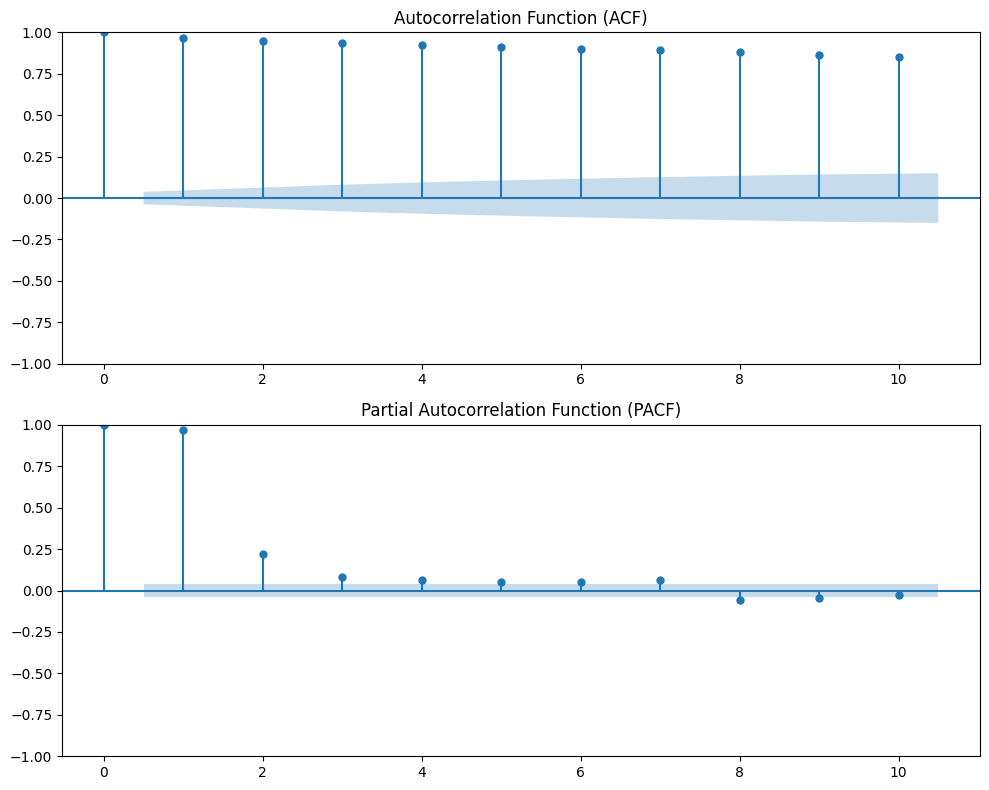

In [ ]:
#製作 ACF 和 PACF 圖來決定要使用的滯後變數的數量
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

target = data['Average']
# Plot ACF and PACF
fig, ax = plt.subplots(nrows=2, figsize=(10, 8))

# ACF plot
plot_acf(target, ax=ax[0], lags=10)
ax[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(target, ax=ax[1], lags=10)
ax[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

# 只選擇Cabbage(Local)	高麗菜（當地）

<Axes: xlabel='Date', ylabel='Average'>

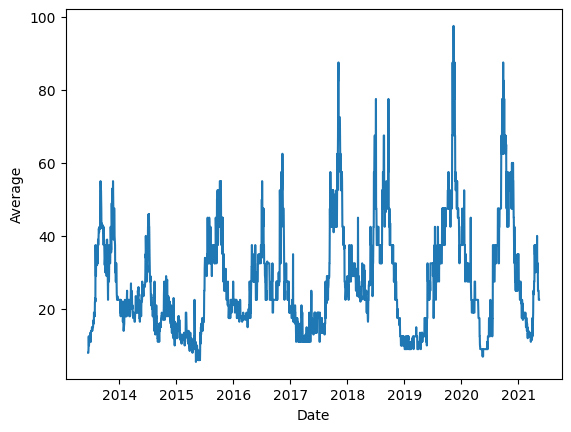

In [ ]:
sns.lineplot(y=data[data['Commodity']=='Cabbage(Local)']['Average'], x=data[data['Commodity']=='Cabbage(Local)']['Date'])

In [ ]:
reset_data = data[data['Commodity']=='Cabbage(Local)'].reset_index(drop=True)
reset_data['year'] = reset_data['Date'].dt.year
reset_data['month'] = reset_data['Date'].dt.month
reset_data['day'] = reset_data['Date'].dt.day
reset_data.head()
print(reset_data.head())
print(reset_data.shape)

        Commodity       Date Unit  Minimum  Maximum  Average  year  month  day
0  Cabbage(Local) 2013-06-16   Kg      6.0     10.0      8.0  2013      6   16
1  Cabbage(Local) 2013-06-17   Kg      6.0     10.0      8.0  2013      6   17
2  Cabbage(Local) 2013-06-18   Kg      8.0     10.0      9.0  2013      6   18
3  Cabbage(Local) 2013-06-19   Kg     10.0     15.0     12.5  2013      6   19
4  Cabbage(Local) 2013-06-20   Kg     10.0     15.0     12.5  2013      6   20
(2749, 9)


In [ ]:
print("開始時間：", reset_data['Date'].min())
print("結束時間：", reset_data['Date'].max())

開始時間： 2013-06-16 00:00:00
結束時間： 2021-05-13 00:00:00


In [ ]:
reset_data.tail() #最後幾個資料

,Commodity,Date,Unit,Minimum,Maximum,Average,year,month,day
2744,Cabbage(Local),2021-05-09,Kg,20.0,30.0,25.0,2021,5,9
2745,Cabbage(Local),2021-05-10,Kg,20.0,30.0,25.0,2021,5,10
2746,Cabbage(Local),2021-05-11,Kg,20.0,25.0,22.5,2021,5,11
2747,Cabbage(Local),2021-05-12,Kg,20.0,25.0,22.5,2021,5,12
2748,Cabbage(Local),2021-05-13,Kg,20.0,25.0,22.5,2021,5,13


In [ ]:
#重量的單位->只剩下一種所以不用再另外處理
reset_data['Unit'].unique()

array(['Kg'], dtype=object)

In [ ]:
#沒有缺失值
missing_values = reset_data[reset_data['Average'].isna()]
print(missing_values)

Empty DataFrame
Columns: [Commodity, Date, Unit, Minimum, Maximum, Average, year, month, day]
Index: []


# LSTM

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional
import matplotlib.pyplot as plt
import time

In [ ]:
data = reset_data

In [ ]:
# 轉換日期格式並排序，用平均價格去預測
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(by='Date')
#data = data[['Average','Maximum','Minimum',]]#先只用平均價格，未來可加上Maximum跟Minimum
data = data[['Date','year','month','day','Average']]# year, month, day

In [ ]:
# 訓練和測試集分割
train_size = int(len(data) * 0.8)
train, test = data[0:train_size], data[train_size:len(data)]

# 標準化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train['Average'].values.reshape(-1, 1))
scaled_test = scaler.transform(test['Average'].values.reshape(-1, 1))

# 查看標準化後的數據
#print(scaled_train.head)

In [ ]:
# 創建數據集
def create_dataset(data, time_step=1):
    dataX, dataY = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(data[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# 設定時間步長，10天
time_step = 10

# 調整數據形狀以符合LSTM模型的輸入要求 [samples, time steps, features]
X_train, y_train = create_dataset(scaled_train, time_step)
X_test, y_test = create_dataset(scaled_test, time_step)
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

2188
2188
539
539


In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2188, 1, 10) (2188,)
(539, 1, 10) (539,)


In [ ]:
# 構建LSTM模型
lstm_model = Sequential()
lstm_model.add(LSTM(64, return_sequences=True, input_shape=(1, time_step)))
lstm_model.add(LSTM(64, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))


# 編譯模型
lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# 訓練模型
start_time = time.time()
history = lstm_model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1, validation_data=[X_test, y_test])
end_time = time.time()
lstm_time = end_time - start_time

Epoch 1/100
69/69 [==============================] - 7s 19ms/step - loss: 0.0185 - mae: 0.0957 - val_loss: 0.0047 - val_mae: 0.0504
Epoch 2/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0031 - mae: 0.0384 - val_loss: 0.0038 - val_mae: 0.0427
Epoch 3/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0026 - mae: 0.0347 - val_loss: 0.0034 - val_mae: 0.0394
Epoch 4/100
69/69 [==============================] - 0s 6ms/step - loss: 0.0022 - mae: 0.0317 - val_loss: 0.0033 - val_mae: 0.0409
Epoch 5/100
69/69 [==============================] - 0s 6ms/step - loss: 0.0020 - mae: 0.0298 - val_loss: 0.0024 - val_mae: 0.0315
Epoch 6/100
69/69 [==============================] - 1s 8ms/step - loss: 0.0019 - mae: 0.0284 - val_loss: 0.0027 - val_mae: 0.0324
Epoch 7/100
69/69 [==============================] - 1s 8ms/step - loss: 0.0020 - mae: 0.0292 - val_loss: 0.0024 - val_mae: 0.0313
Epoch 8/100
69/69 [==============================] - 1s 9ms/step - loss: 0.0021 - 

In [ ]:
lstm_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 1, 64)             19200     
                                                                 
 lstm_9 (LSTM)               (None, 64)                33024     
                                                                 
 dense_14 (Dense)            (None, 25)                1625      
                                                                 
 dense_15 (Dense)            (None, 1)                 26        
                                                                 
Total params: 53875 (210.45 KB)
Trainable params: 53875 (210.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# 評估模型

In [ ]:
# 預測
train_predict = lstm_model.predict(X_train)
test_predict = lstm_model.predict(X_test)

# 反標準化
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

17/17 [==============================] - 0s 2ms/step


In [ ]:
#真實數據
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
#對 y_train 和 y_test 進行了反標準化處理，以確保誤差指標反映的是原始數據的誤差
#更適合用於評估模型在真實世界中的預測性能
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

trainPredict = lstm_model.predict(X_train)
testPredict = lstm_model.predict(X_test)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([y_test])

#因為MAPE是inf無限大，所以有改5/27
def mean_absolute_percentage_error(y_true, y_pred):
    epsilon = np.finfo(np.float64).eps  # 添加一個非常小的數值以避免除以零
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100
    return mape

print('MSE: ', mean_squared_error(testY[0], testPredict[:,0]))
print('RMSE: ', np.sqrt(mean_squared_error(testY[0], testPredict[:,0])))
print('MAE: ', mean_absolute_error(testY[0], testPredict[:,0]))
print('MAPE: ', mean_absolute_percentage_error(testY[0], testPredict[:,0]))

17/17 [==============================] - 0s 2ms/step
MSE:  16.10612627338289
RMSE:  4.013243859197058
MAE:  2.4256039798149156
MAPE:  7.6055772049872825


In [ ]:
print(
    "Train loss: ",
    history.history["loss"][-1],
    "\nTest loss:",
    history.history["val_loss"][-1],
    "\nTrain mae:",
    history.history["mae"][-1],
    "\nTest mae:",
    history.history["val_mae"][-1],
)

Train loss:  0.0018109820084646344 
Test loss: 0.0023953192867338657 
Train mae: 0.027087340131402016 
Test mae: 0.02958053909242153


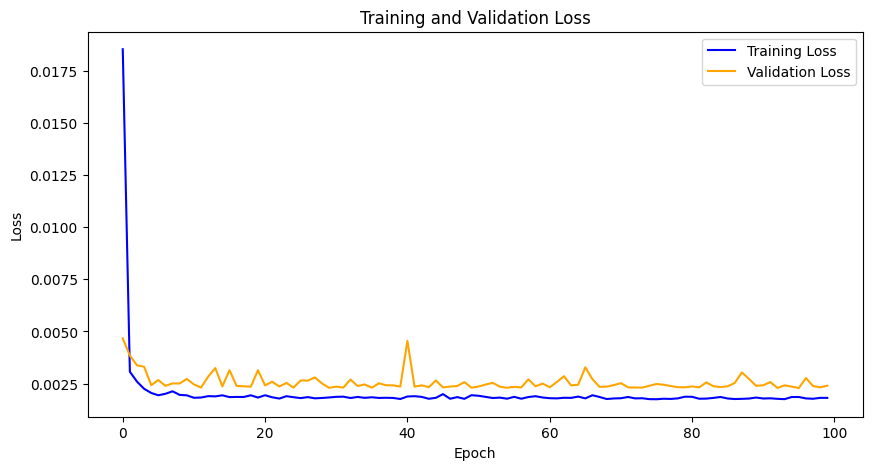

In [ ]:
import matplotlib.pyplot as plt

# 繪製訓練和驗證損失
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label='Training Loss', color='blue')
plt.plot(history.history["val_loss"], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

X_train, y_train
X_test, y_test

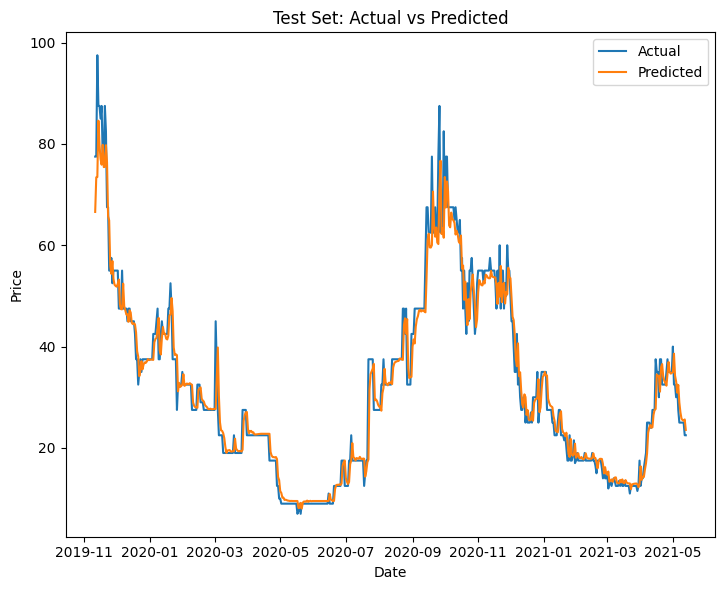

In [ ]:
# 預測結果與實際結果對比
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 2)
plt.plot(test['Date'][time_step+1:], y_test_actual, label='Actual')
plt.plot(test['Date'][time_step+1:], test_predict, label='Predicted')
plt.title('Test Set: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.show()

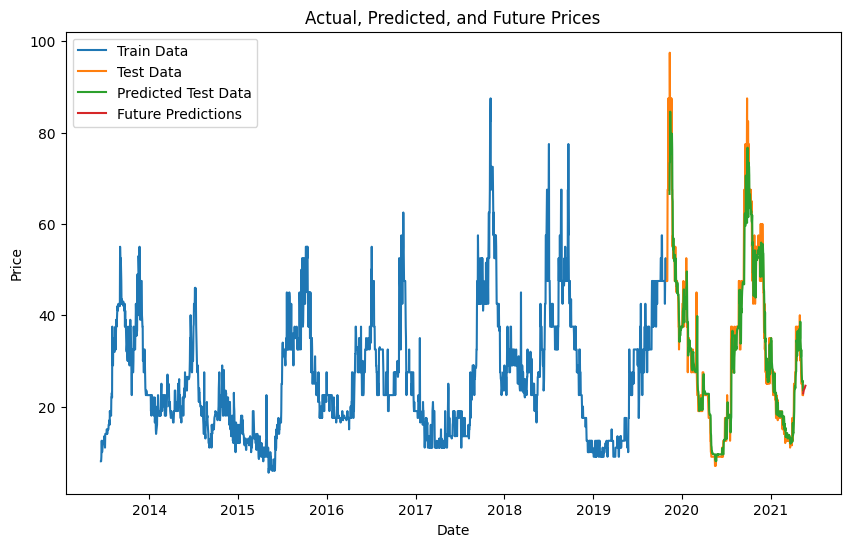

In [ ]:
# 預測未來價格
def predict_future_prices(model, data, time_step, future_days):
    temp_input = data[-time_step:].reshape(1, -1).tolist()[0]
    future_output = []
    for i in range(future_days):
        if len(temp_input) > time_step:
            temp_input = temp_input[1:]
        temp_input_scaled = np.array(temp_input).reshape((1, 1, time_step))
        next_pred = model.predict(temp_input_scaled, verbose=0)
        future_output.append(next_pred[0][0])
        temp_input.append(next_pred[0][0])
    return np.array(future_output).reshape(-1, 1)

# 設定要預測的未來天數
future_days = 10
future_predictions = predict_future_prices(lstm_model, scaled_test, time_step, future_days)
future_predictions = scaler.inverse_transform(future_predictions)

# 繪製圖表
plt.figure(figsize=(10, 6))
plt.plot(train['Date'], train['Average'], label='Train Data')
plt.plot(test['Date'], test['Average'], label='Test Data')
plt.plot(test['Date'][time_step+1:], test_predict, label='Predicted Test Data')
future_dates = pd.date_range(start=test['Date'].values[-1], periods=future_days+1, inclusive='right')
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.legend()
plt.title('Actual, Predicted, and Future Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [ ]:
print("LSTM訓練時間：", lstm_time, "秒")

LSTM訓練時間： 87.06641054153442 秒


In [ ]:
# 顯示未來10天的預測價格
print(future_predictions)

[[22.88489 ]
 [23.224125]
 [23.479767]
 [23.762812]
 [23.812462]
 [23.898298]
 [24.055603]
 [24.216742]
 [24.391867]
 [24.558752]]


In [ ]:
import pandas as pd
future_predictions = [[22.88489],
                      [23.224125],
                      [23.479767],
                      [23.762812],
                      [23.812462],
                      [23.898298],
                      [24.055603],
                      [24.216742],
                      [24.391867],
                      [24.558752]]

# 假設今天是2024-06-18
start_date = pd.to_datetime('2021-05-13')

# 顯示未來10天的預測價格
print("未來10天的預測價格：")
for i, prediction in enumerate(future_predictions):
    date = start_date + pd.Timedelta(days=i)
    print(f"{date.strftime('%Y-%m-%d')}: {prediction[0]:.1f}")

未來10天的預測價格：
2021-05-13: 22.9
2021-05-14: 23.2
2021-05-15: 23.5
2021-05-16: 23.8
2021-05-17: 23.8
2021-05-18: 23.9
2021-05-19: 24.1
2021-05-20: 24.2
2021-05-21: 24.4
2021-05-22: 24.6


# RNN

In [ ]:
from tensorflow.keras.layers import SimpleRNN

# 構建RNN模型
rnn_model = Sequential()
rnn_model.add(SimpleRNN(64, return_sequences=True, input_shape=(1, time_step)))
rnn_model.add(SimpleRNN(64, return_sequences=False))
rnn_model.add(Dropout(0.8))
rnn_model.add(Dense(25))
rnn_model.add(Dense(1))

# 編譯模型
rnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# 訓練模型
start_time = time.time()
history = rnn_model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1, validation_data=[X_test, y_test])
end_time = time.time()
rnn_time = end_time - start_time


Epoch 1/100
69/69 [==============================] - 5s 14ms/step - loss: 0.0556 - mae: 0.1472 - val_loss: 0.0063 - val_mae: 0.0578
Epoch 2/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0097 - mae: 0.0701 - val_loss: 0.0041 - val_mae: 0.0441
Epoch 3/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0076 - mae: 0.0617 - val_loss: 0.0053 - val_mae: 0.0478
Epoch 4/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0061 - mae: 0.0559 - val_loss: 0.0037 - val_mae: 0.0395
Epoch 5/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0057 - mae: 0.0531 - val_loss: 0.0028 - val_mae: 0.0367
Epoch 6/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0051 - mae: 0.0493 - val_loss: 0.0036 - val_mae: 0.0391
Epoch 7/100
69/69 [==============================] - 0s 6ms/step - loss: 0.0051 - mae: 0.0495 - val_loss: 0.0038 - val_mae: 0.0391
Epoch 8/100
69/69 [==============================] - 0s 5ms/step - loss: 0.0046 - 

In [ ]:
rnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 1, 64)             4800      
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 25)                1625      
                                                                 
 dense_17 (Dense)            (None, 1)                 26        
                                                                 
Total params: 14707 (57.45 KB)
Trainable params: 14707 (57.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# 評估模型

In [ ]:
#對 y_train 和 y_test 進行了反標準化處理，以確保誤差指標反映的是原始數據的誤差
#更適合用於評估模型在真實世界中的預測性能
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# 預測
train_predict_rnn = rnn_model.predict(X_train)
test_predict_rnn = rnn_model.predict(X_test)

# 反標準化
trainPredict_rnn = scaler.inverse_transform(train_predict_rnn)
trainY = scaler.inverse_transform([y_train])
testPredict_rnn = scaler.inverse_transform(test_predict_rnn)
testY = scaler.inverse_transform([y_test])

#因為MAPE是inf無限大，所以有改5/27
def mean_absolute_percentage_error(y_true, y_pred):
    epsilon = np.finfo(np.float64).eps  # 添加一個非常小的數值以避免除以零
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100
    return mape

print('MSE: ', mean_squared_error(testY[0], testPredict_rnn[:,0]))
print('RMSE: ', np.sqrt(mean_squared_error(testY[0], testPredict_rnn[:,0])))
print('MAE: ', mean_absolute_error(testY[0], testPredict_rnn[:,0]))
print('MAPE: ', mean_absolute_percentage_error(testY[0], testPredict_rnn[:,0]))

17/17 [==============================] - 0s 3ms/step
MSE:  15.598108945093921
RMSE:  3.9494441311523727
MAE:  2.2943382360497298
MAPE:  7.060458414489451


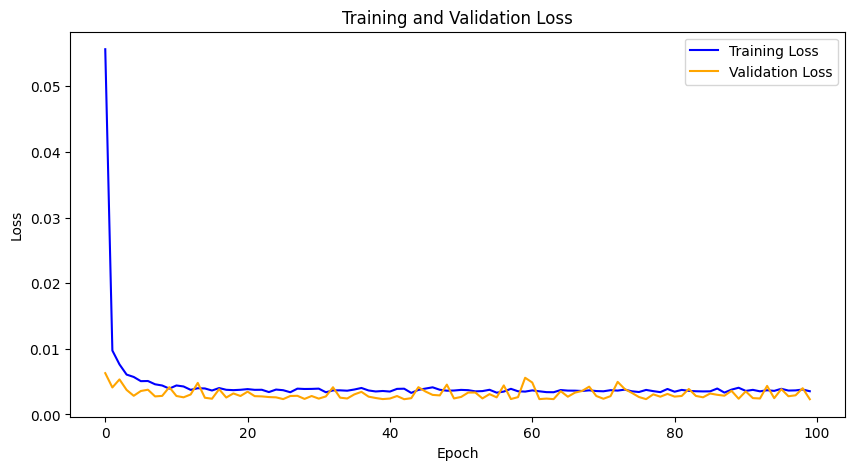

In [ ]:
import matplotlib.pyplot as plt

# 繪製訓練和驗證損失
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label='Training Loss', color='blue')
plt.plot(history.history["val_loss"], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
print(
    "Train loss: ",
    history.history["loss"][-1],
    "\nTest loss:",
    history.history["val_loss"][-1],
    "\nTrain mae:",
    history.history["mae"][-1],
    "\nTest mae:",
    history.history["val_mae"][-1],
)

Train loss:  0.0035373568534851074 
Test loss: 0.002319766441360116 
Train mae: 0.041941575706005096 
Test mae: 0.02797972969710827


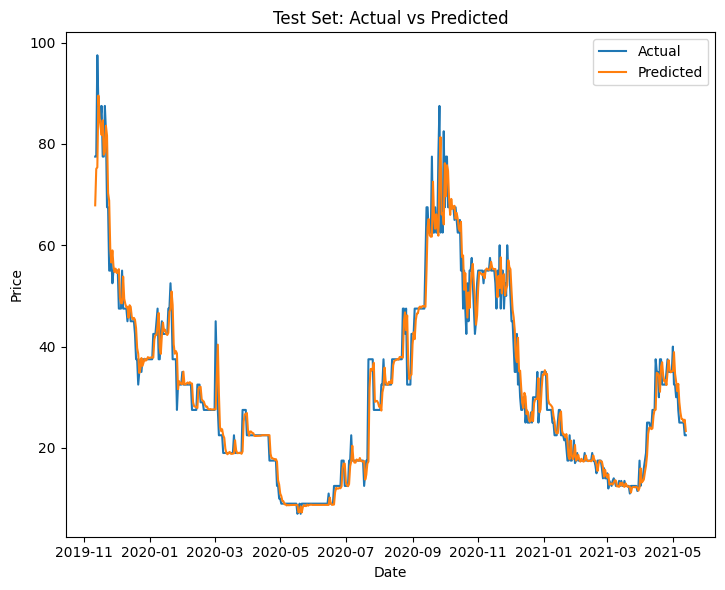

In [ ]:
# 預測結果與實際結果對比
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 2)
plt.plot(test['Date'][time_step+1:], y_test_actual, label='Actual')
plt.plot(test['Date'][time_step+1:], testPredict_rnn, label='Predicted')
plt.title('Test Set: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.show()

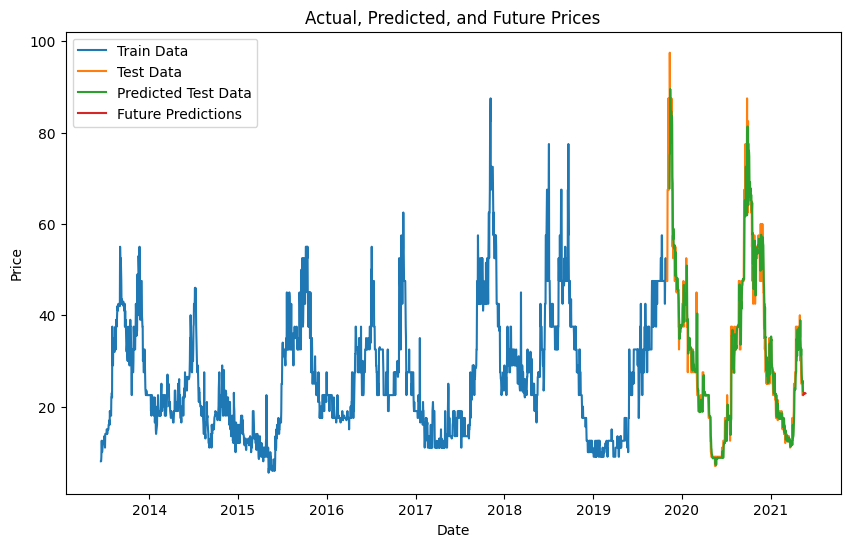

In [ ]:
# 預測未來價格
def predict_future_prices(model, data, time_step, future_days):
    temp_input = data[-time_step:].reshape(1, -1).tolist()[0]
    future_output = []
    for i in range(future_days):
        if len(temp_input) > time_step:
            temp_input = temp_input[1:]
        temp_input_scaled = np.array(temp_input).reshape((1, 1, time_step))
        next_pred = model.predict(temp_input_scaled, verbose=0)
        future_output.append(next_pred[0][0])
        temp_input.append(next_pred[0][0])
    return np.array(future_output).reshape(-1, 1)

# 設定要預測的未來天數
future_days = 10
future_predictions = predict_future_prices(rnn_model, scaled_test, time_step, future_days)
future_predictions = scaler.inverse_transform(future_predictions)

# 繪製圖表
plt.figure(figsize=(10, 6))
plt.plot(train['Date'], train['Average'], label='Train Data')
plt.plot(test['Date'], test['Average'], label='Test Data')
plt.plot(test['Date'][time_step+1:], testPredict_rnn, label='Predicted Test Data')
future_dates = pd.date_range(start=test['Date'].values[-1], periods=future_days+1, inclusive='right')
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.legend()
plt.title('Actual, Predicted, and Future Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [ ]:
print("RNN訓練時間：", rnn_time, "秒")

RNN訓練時間： 45.268210649490356 秒


In [ ]:
# 顯示未來10天的預測價格
print(future_predictions)

[[22.597647]
 [22.75909 ]
 [22.850174]
 [23.013653]
 [22.89865 ]
 [22.833118]
 [22.800951]
 [22.825333]
 [22.855837]
 [22.881674]]


In [ ]:
import pandas as pd
future_predictions = [[22.597647],
                      [22.75909],
                      [22.850174],
                      [23.013653],
                      [22.89865],
                      [22.833118],
                      [22.800951],
                      [22.825333],
                      [22.855837],
                      [22.881674]]

# 假設今天是2024-06-18
start_date = pd.to_datetime('2021-05-13')

# 顯示未來10天的預測價格
print("未來10天的預測價格：")
for i, prediction in enumerate(future_predictions):
    date = start_date + pd.Timedelta(days=i)
    print(f"{date.strftime('%Y-%m-%d')}: {prediction[0]:.1f}")

未來10天的預測價格：
2021-05-13: 22.6
2021-05-14: 22.8
2021-05-15: 22.9
2021-05-16: 23.0
2021-05-17: 22.9
2021-05-18: 22.8
2021-05-19: 22.8
2021-05-20: 22.8
2021-05-21: 22.9
2021-05-22: 22.9
